In [1]:
#%matplotlib notebook
import sys
sys.path.append('../code')

from mpl_toolkits.mplot3d import Axes3D
from krr import KernelRidgeRegression, krr, k_polynomial, k_gaussian, k_tanh
from label_data import LabelData
import numpy as np
import matplotlib.pyplot as plt
from mnist_load import *

import time

In [2]:
usage = 0.1
ratio = 0.5
s0, s1 = 1,7
mnist, names = load_mnist_data(s0, s1, ratio, usage)

In [3]:
print("MNIST Training Dimensions: (%d, %d)\nMNIST Validation Dimensions: (%d, %d)" % (*mnist.training[0].shape, 
                                                                                      *mnist.validation[0].shape))

MNIST Training Dimensions: (758, 784)
MNIST Validation Dimensions: (759, 784)


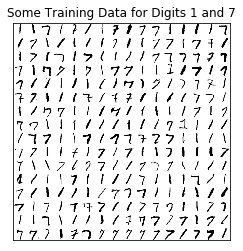

In [4]:
fig, ax = plt.subplots()
view_digits(ax, mnist.training[0][0:256], 16, 16)
plt.title("Some Training Data for Digits %d and %d" % (s0, s1))
plt.show()

In [5]:
ld = LabelData()
print(mnist.training[1].shape, mnist.validation[1].shape)
ld.add_data(mnist.training[0], mnist.training[1])

t0 = time.time()
kregr = KernelRidgeRegression(ld, k=lambda x,y: k_polynomial(x, y, 2), l=.0001)
t1 = time.time()
total = t1-t0
print("Training Time: %2.3f s" % total)


(758,) (759,)
Training Time: 1.256 s


In [6]:
t0 = time.time()
y_v = kregr(mnist.validation[0])
y_v[y_v > 0.5]= 1
y_v[y_v < 0.5]= -1
t1 = time.time()
total = t1-t0
print("Validation Time: %2.3f s" % total)

t0 = time.time()
y_t = kregr(mnist.training[0])
y_t[y_t > 0.5]= 1
y_t[y_t < 0.5]= -1
t1 = time.time()
total = t1-t0
print("Risk Time: %2.3f s" % total)
print(y_t)

Validation Time: 2.668 s
Risk Time: 2.549 s
[-1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1.
 -1. -1. -1. -1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.
 -1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.
 -1.  1.  1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1.
  1. -1.  1. -1.  1.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1.
 -1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1. -1. -1.
 -1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1.
 -1. -1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
  1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.
 -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1. -1.
 -1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1.
  1.  1

In [8]:
error = risk(mnist.validation[1], y_v)
erisk = risk(mnist.training[1], y_t)

print("Empirical Risk: %2.5f%%" % (erisk*100))
print("Classification Error: %2.5f%%" % (error*100))

Empirical Risk: 27.63852%
Classification Error: 28.19499%


In [9]:
def classify_test(s0, s1, usage, ratio, k):
    mnist, names = load_mnist_data(s0, s1, ratio, usage)

    ld = LabelData()
    ld.add_data(mnist.training[0], mnist.training[1])

    t0 = time.time()
    kregr = KernelRidgeRegression(ld, k=k, l=.0001)
    t1 = time.time()
    ttotal = t1 - t0

    t0 = time.time()
    y_v = np.array([krr(ld, kregr._alpha, k, x) for x in mnist.validation[0]])
    y_v[y_v > 0.5] = 1
    y_v[y_v < 0.5] = 0
    t1 = time.time()
    vtotal = t1 - t0

    t0 = time.time()
    y_t = np.array([krr(ld, kregr._alpha, k, x) for x in mnist.training[0]])
    y_t[y_t > 0.5] = 1
    y_t[y_t < 0.5] = 0
    t1 = time.time()
    rtotal = t1 - t0

    error = risk(mnist.validation[1], y_v)
    erisk = risk(mnist.training[1], y_t)

    return {"error": error, "risk": erisk, "training time": ttotal, "validation time": vtotal, "risk time": rtotal,
            "training size": mnist.training[1].shape[0], "validation size": mnist.validation[1].shape[0]}

In [10]:
cerror = np.zeros((10, 10))
print('& '+ str(list(range(0, 10)))[1:-1].replace(',', '&') + " \\\\ \hline")
for s0 in range(0, 10):
    row_str = str(s0) + ' &'
    for s1 in range(0, 10):
        if s1 < s0:
            res = classify_test(s0, s1, 0.03, 0.5, lambda x, y: k_polynomial(x, y, 2))
            cerror[s0, s1] = res['error']
            row_str += "%2.2f " % (cerror[s0, s1]*100)
        if s1 < 9:
            row_str += ' &'
        else:
            row_str += '\\\\ \hline'
    print(row_str)
        #print(s0, s1, res['error'])

& 0& 1& 2& 3& 4& 5& 6& 7& 8& 9 \\ \hline
0 & & & & & & & & & &\\ \hline
1 &0.45  & & & & & & & & &\\ \hline
2 &3.59  &4.04  & & & & & & & &\\ \hline
3 &2.37  &1.11  &2.36  & & & & & & &\\ \hline


KeyboardInterrupt: 

In [11]:
samps = np.logspace(1, 3, 20).astype(np.int)
ress = []
for s in samps:
    usage = 2*s/15000
    print(usage)
    res = classify_test(4, 9, usage, 0.5, lambda x, y: k_polynomial(x, y, 2))
    ress.append(res)

0.0013333333333333333
0.0016
0.0021333333333333334
0.0026666666666666666
0.0034666666666666665
0.0044
0.0056
0.0072
0.0092
0.011733333333333333
0.014933333333333333
0.019066666666666666
0.0244
0.031066666666666666
0.0396
0.05053333333333333
0.0644
0.082
0.10453333333333334
0.13333333333333333


In [ ]:
errs = []
risks = []
ttimes = []
vtimes = []
tsize = []

for r in ress:
    errs.append(r['error'])
    risks.append(r['risk'])
    ttimes.append(r['training time'])
    vtimes.append(r['validation time'])
    tsize.append(r['training size'])
    
    

In [ ]:
from matplotlib import rc
rc('mathtext', default='regular')

fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.semilogx(tsize, (1 - np.array(errs))*s, color='r', label='Correctly Classified Images')

ax2 = ax.twinx()
lns2 = ax2.loglog(tsize, ttimes, label='Training Time (s)')
lns3 = ax2.loglog(tsize, vtimes, label='Testing Time (s)')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.set_xlabel('Training Size (samples)')
ax.set_ylabel('Number of Images')
ax2.set_ylabel('Time (s)')

plt.savefig("mnist.eps", format='eps')
#plt.show()
